<a href="https://colab.research.google.com/github/alfazick/AppliedLLMCourse/blob/main/MultiModalObtainInferenceOnly3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ok finally looks it's working prepare only inference dataset
# I have the feeling of potential issues but let's just run inference and save
# output without any parsing
# plain dic format key image_id: value boxes
!pip install flash-attn --no-build-isolation

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 15.4 MB/s  0:00:00 eta 0:00:01
  Preparing metadata (pyproject.toml) ... done
  Created wheel for flash-attn: filename=flash_attn-2.8.3-cp312-cp312-linux_x86_64.whl size=256040057 sha256=f25da18657a87fc83dc1bfb8b7751b82246e9db355510226b674fd437c34b5fb
  Stored in directory: /workspace/.cache/pip/wheels/3d/59/46/f282c12c73dd4bb3c2e3fe199f1a0d0f8cec06df0cccfeee27
Successfully built flash-attn
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [flash-attn]2 [flash-attn]


In [ ]:
# Cell 2 - MUST restart kernel
import os
os._exit(0)  # This forces kernel restart


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128,expandable_segments:True"
os.environ["PYTORCH_NO_CUDA_MEMORY_CACHING"] = "1"



In [ ]:
import torch
print("alloc conf:", os.environ.get("PYTORCH_CUDA_ALLOC_CONF"))


alloc conf: max_split_size_mb:128,expandable_segments:True


In [ ]:
import importlib

# Verify installed versions match requirements
requirements = {
    'torch': '2.4.1',
    'transformers': '4.46.2',
    'trl': '0.11.4',
    'datasets': '3.0.2',
    'bitsandbytes': '0.44.1',
    'peft': '0.13.2',
    'qwen_vl_utils': '0.0.8',
    'wandb': '0.18.5',
    'accelerate': '1.0.1'
}

print("=== VERSION CHECK ===")
for package, expected in requirements.items():
    try:
        module = importlib.import_module(package)
        actual = getattr(module, '__version__', 'unknown')
        status = "✅" if actual == expected else "⚠️"
        print(f"{status} {package}: {actual} (expected: {expected})")
    except ImportError:
        print(f"❌ {package}: NOT INSTALLED (expected: {expected})")

=== VERSION CHECK ===
⚠️ torch: 2.8.0+cu128 (expected: 2.4.1)
✅ transformers: 4.46.2 (expected: 4.46.2)
✅ trl: 0.11.4 (expected: 0.11.4)
✅ datasets: 3.0.2 (expected: 3.0.2)
⚠️ bitsandbytes: 0.48.2 (expected: 0.44.1)
✅ peft: 0.13.2 (expected: 0.13.2)
⚠️ qwen_vl_utils: unknown (expected: 0.0.8)
✅ wandb: 0.18.5 (expected: 0.18.5)
✅ accelerate: 1.0.1 (expected: 1.0.1)


In [ ]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if 'inputs' in globals(): del globals()['inputs']
    if 'model' in globals(): del globals()['model']
    if 'processor' in globals(): del globals()['processor']
    if 'trainer' in globals(): del globals()['trainer']
    if 'peft_model' in globals(): del globals()['peft_model']
    if 'bnb_config' in globals(): del globals()['bnb_config']
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

clear_memory()

GPU allocated memory: 0.00 GB
GPU reserved memory: 0.00 GB


In [ ]:
!nvidia-smi

Sat Nov 22 02:02:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090        On  |   00000000:01:00.0 Off |                  N/A |
|  0%   33C    P1             66W /  575W |     506MiB /  32607MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
import os
from matplotlib import pyplot as plt
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor,AutoProcessor
from qwen_vl_utils import vision_process,process_vision_info
import peft
import bitsandbytes as bnb
from transformers import BitsAndBytesConfig

# let's start with 8 bit quantization

quantization_config=BitsAndBytesConfig(
        load_in_8bit=True,
        llm_int8_threshold=6.0
    )

processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")



model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    quantization_config=quantization_config,
    device_map="auto",
    attn_implementation="flash_attention_2",
)
print(model.device)
model.eval()



`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

cuda:0


Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionFlashAttention2(
          (qkv): Linear8bitLt(in_features=1280, out_features=3840, bias=True)
          (proj): Linear8bitLt(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear8bitLt(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear8bitLt(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_aff

In [ ]:
print(model.device)

cuda:0


In [ ]:
!nvidia-smi

Sat Nov 22 02:03:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090        On  |   00000000:01:00.0 Off |                  N/A |
|  0%   34C    P1             67W /  575W |    9844MiB /  32607MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:

system_message = """You are a Vision Language Model specialized in interpreting visual data from product images.
Your task is to analyze the provided product images and detect the nutrition tables in a certain format.
Focus on delivering accurate, succinct answers based on the visual information. Avoid additional explanation unless absolutely necessary."""

prompt = "Detect the bounding box of the nutrition table in this image and respond in <|bbox|> format <|bbox|> "

def generate_messages(image_link):
    messages = [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}]
        },
        {
            "role":"user",
            "content":[
                {
                    "type":"image","image":image_link,

                },
                {
                    "type":"text","text":prompt
                },
            ]
        }
    ]
    return messages



In [ ]:
from datasets import load_dataset
dataset_id = "openfoodfacts/nutrition-table-detection"
nutrition_data = load_dataset(dataset_id)


In [ ]:
sample = nutrition_data['train'][0]
sample

{'image_id': '0009800892204_1',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2592x1944>,
 'width': 2592,
 'height': 1944,
 'meta': {'barcode': '0009800892204',
  'off_image_id': '1',
  'image_url': 'https://static.openfoodfacts.org/images/products/000/980/089/2204/1.jpg'},
 'objects': {'bbox': [[0.057098764926195145,
    0.014274691231548786,
    0.603501558303833,
    0.991126537322998]],
  'category_id': [0],
  'category_name': ['nutrition-table']}}

In [ ]:
image_link = sample["meta"]["image_url"]
messages = generate_messages(image_link)

In [ ]:
def run_inference(image_link):
    torch.cuda.empty_cache()
    messages = generate_messages(image_link)

    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    )
    inputs = inputs.to(model.device)

    # 1. Capture input lengths BEFORE generation/deletion
    input_len = inputs.input_ids.shape[1]

    with torch.inference_mode():
        generated_ids = model.generate(**inputs, max_new_tokens=128)

    # 2. NOW you can safely delete inputs to free VRAM
    del inputs
    torch.cuda.empty_cache()

    # 3. Use the pre-calculated length to trim
    # Note: Since batch size is 1, we can simplify the list comprehension
    generated_ids_trimmed = [out_ids[input_len:] for out_ids in generated_ids]

    output_text = processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True)
    result = output_text[0]

    # Cleanup
    del generated_ids, generated_ids_trimmed, image_inputs, video_inputs, text, messages
    torch.cuda.empty_cache()

    return result

In [ ]:
res = run_inference(image_link)

In [ ]:
res

'[0.03, 0.16, 0.96, 0.57]'

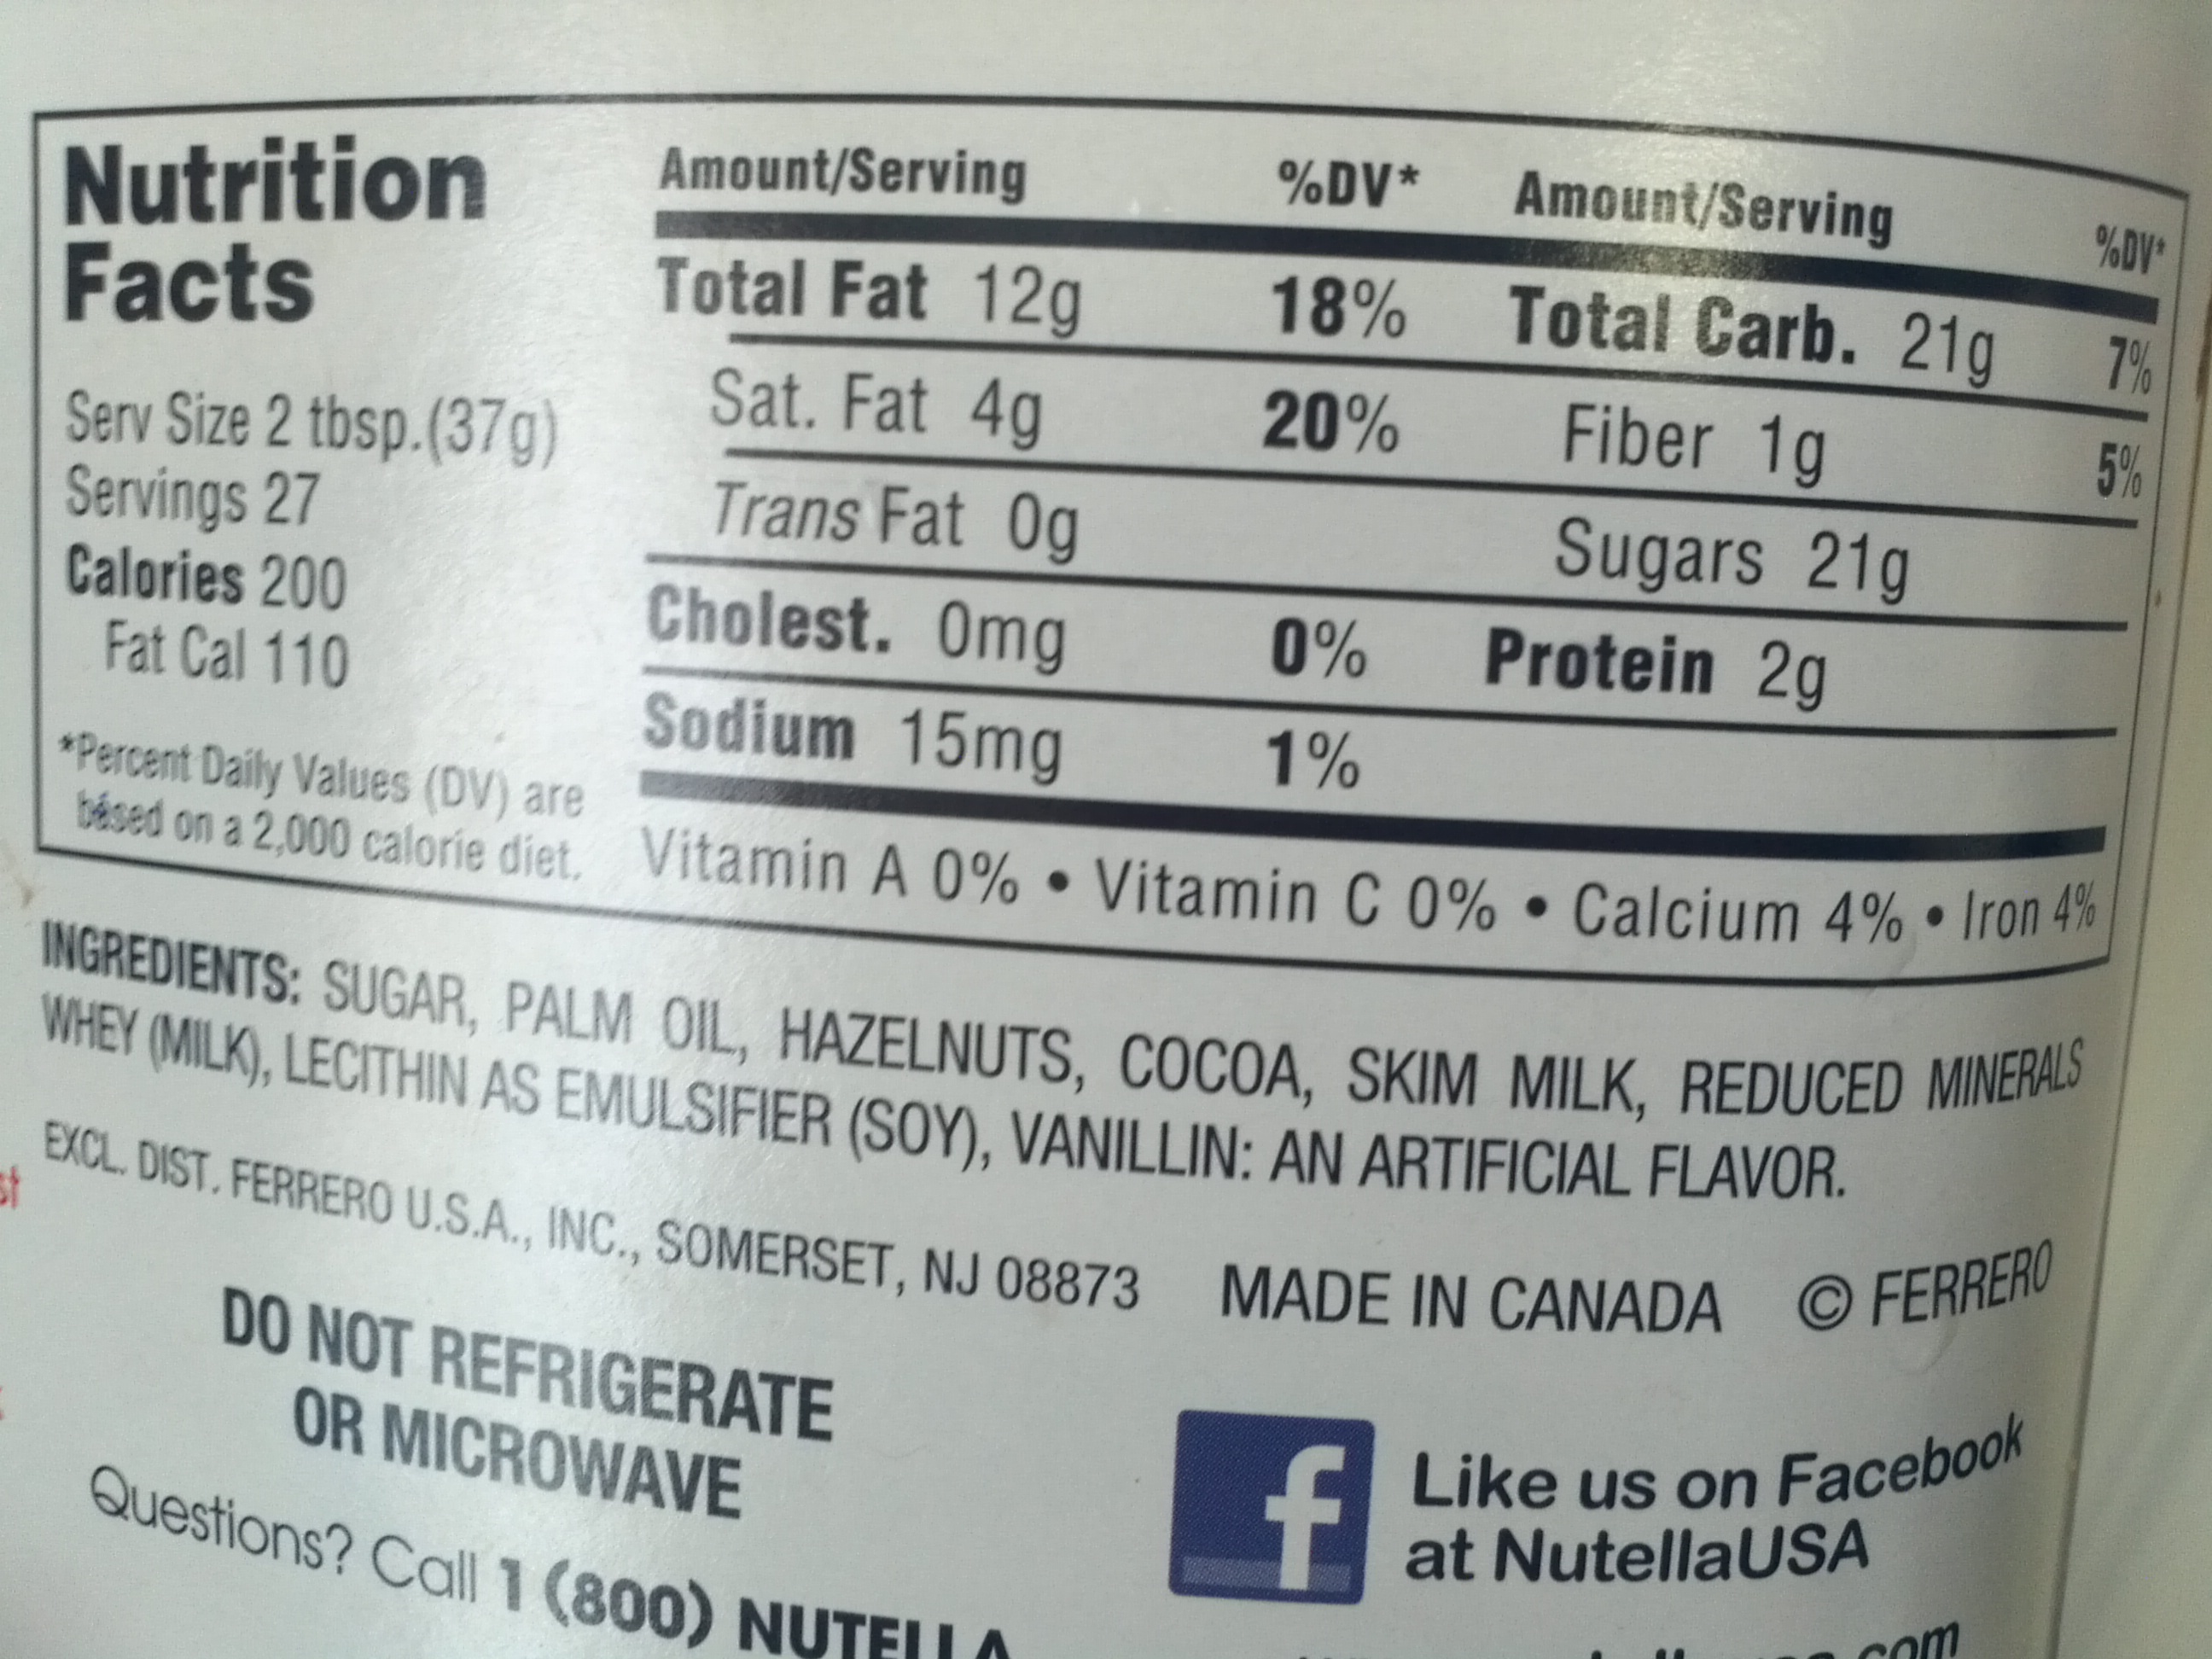

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

import requests
from PIL import Image
from io import BytesIO

# 1. Fetch the image data from the link
response = requests.get(image_link)

# 2. Convert raw bytes into a PIL Image object
image = Image.open(BytesIO(response.content))

# 3. Display it to confirm
image

<Figure size 1000x1000 with 0 Axes>

(np.float64(-0.5), np.float64(2591.5), np.float64(1943.5), np.float64(-0.5))

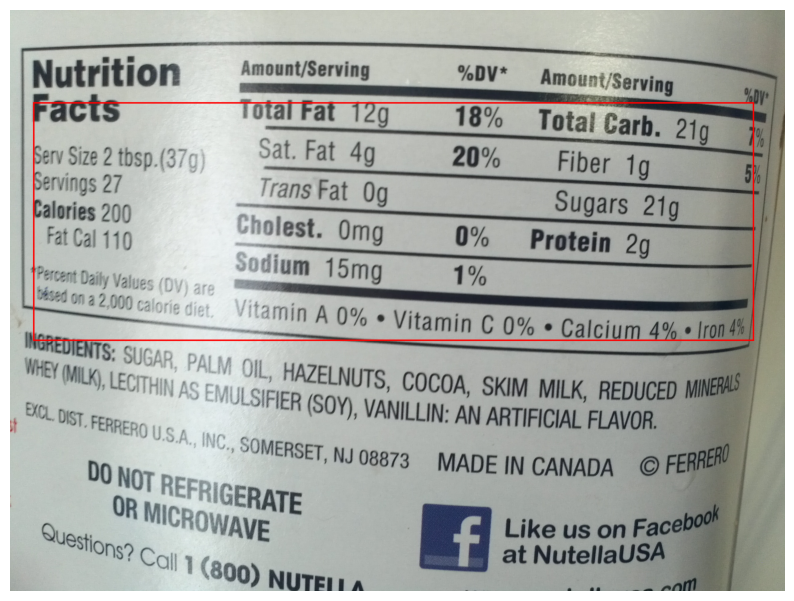

In [ ]:
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt

bbox_norm = [0.03, 0.16, 0.96, 0.57]

def draw_bbox_on_image(image, bbox_norm):
    # Create a copy so we don't modify the original
    img_draw = image.copy()
    draw = ImageDraw.Draw(img_draw)

    width, height = img_draw.size
    xmin,ymin,xmax,ymax = bbox_norm

    # Convert normalized coordinates to absolute pixels
    # PIL expects [x_min, y_min, x_max, y_max]
    box_pixel = [
        xmin * width,  # x_min
        ymin * height, # y_min
        xmax * width,  # x_max
        ymax * height  # y_max
    ]

    # Draw the rectangle
    draw.rectangle(box_pixel, outline="red", width=5)

    return img_draw

# Visualize
annotated_image = draw_bbox_on_image(image, bbox_norm)
plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.axis("off")
plt.show()

In [ ]:
# ok not that bad